In [15]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from xgboost import XGBRegressor, Booster
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import os
import joblib

In [16]:
base_dir = Path('/home/mohammed/Downloads')
train_csv = base_dir / 'data/nyu2_train.csv'
test_csv = base_dir / 'data/nyu2_test.csv'
# Load dataset
df = pd.read_csv(train_csv, header=None)
df[0] = df[0].map(lambda x: str(base_dir / x))
df[1] = df[1].map(lambda x: str(base_dir / x))
# Use a smaller subset for testing
df = df.sample(n=10, random_state=42).reset_index(drop=True) # Use only 10 samples
# Split dataset
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42) # 90% trai
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [17]:
def extract_pixel_features(image_path, target_size=(64, 64)):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    return image.reshape(-1, 3) # Flatten to (height * width, channels)
def extract_depth_labels(depth_path, target_size=(64, 64)):

    depth = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
    depth = cv2.resize(depth, target_size)
    return depth.flatten()
train_features, train_labels = [], []
val_features, val_labels = [], []

In [18]:
print("Extracting features and labels for training set...")
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    image_features = extract_pixel_features(row[0])
    depth_labels = extract_depth_labels(row[1])
    train_features.append(image_features)
    train_labels.append(depth_labels)

print("Extracting features and labels for validation set...")
for _, row in tqdm(val_df.iterrows(), total=len(val_df)):
    image_features = extract_pixel_features(row[0])
    depth_labels = extract_depth_labels(row[1])
    val_features.append(image_features)
    val_labels.append(depth_labels)

# Convert to numpy arrays
train_features = np.vstack(train_features)  # (num_pixels_total, 3)
train_labels = np.hstack(train_labels)  # (num_pixels_total,)
val_features = np.vstack(val_features)
val_labels = np.hstack(val_labels)

# Scale features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

model_path = "xgb_model_50_50.json"

if os.path.exists(model_path):
    print(f"Model {model_path} exists. Loading the model...")
    booster = Booster({'gpu_id': 0})
    booster.load_model(model_path)
else:
    print("Model does not exist. Training XGBoost...")
    xgb_gpu = XGBRegressor(
        tree_method="hist",
        device="cuda",
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )
    xgb_gpu.fit(train_features, train_labels)
    xgb_gpu.save_model(model_path)
    booster = xgb_gpu.get_booster()

Extracting features and labels for training set...


100%|██████████| 9/9 [00:00<00:00, 448.32it/s]


Extracting features and labels for validation set...


100%|██████████| 1/1 [00:00<00:00, 497.43it/s]

Model xgb_model_50_50.json exists. Loading the model...


In [19]:
svm_path = "svm_model.pkl"

if os.path.exists(svm_path):
    print(f"Model {svm_path} exists. Loading the model...")
    svr = joblib.load(svm_path)
else:
    print("Model does not exist. Training SVM...")
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(train_features, train_labels)
    joblib.dump(svr, svm_path)

# Predict using SVM
print("Evaluating SVM...")
train_preds_svr = svr.predict(train_features)
val_preds_svr = svr.predict(val_features)

Model svm_model.pkl exists. Loading the model...
Evaluating SVM...


Visualizing XGBoost prediction...


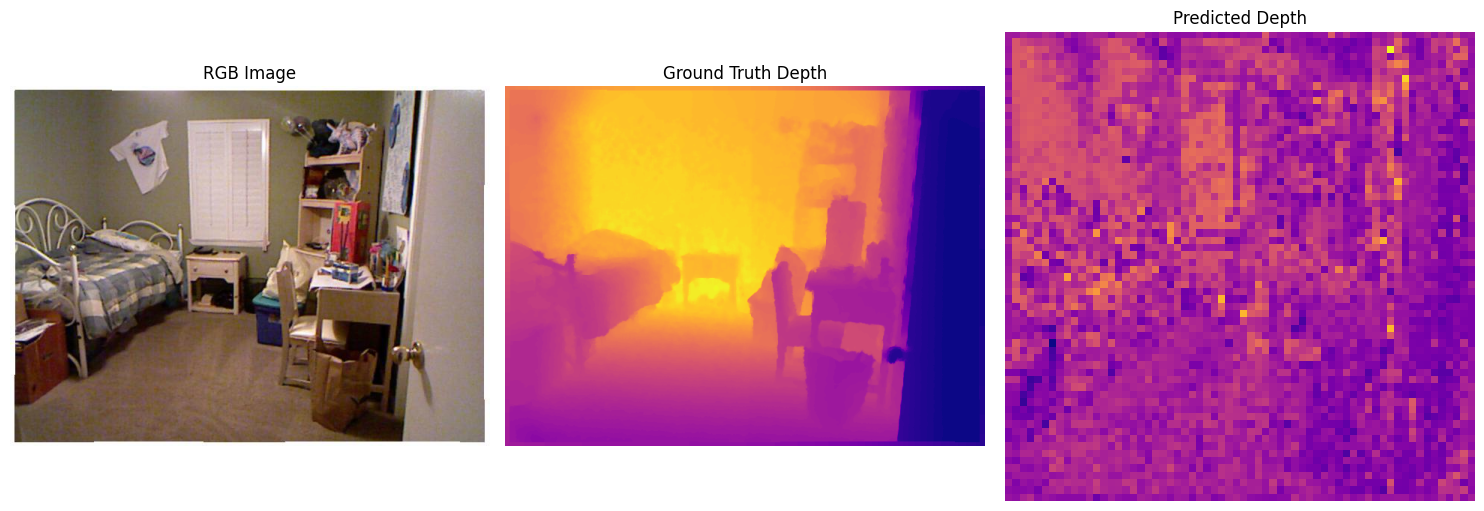

Visualizing SVM prediction...


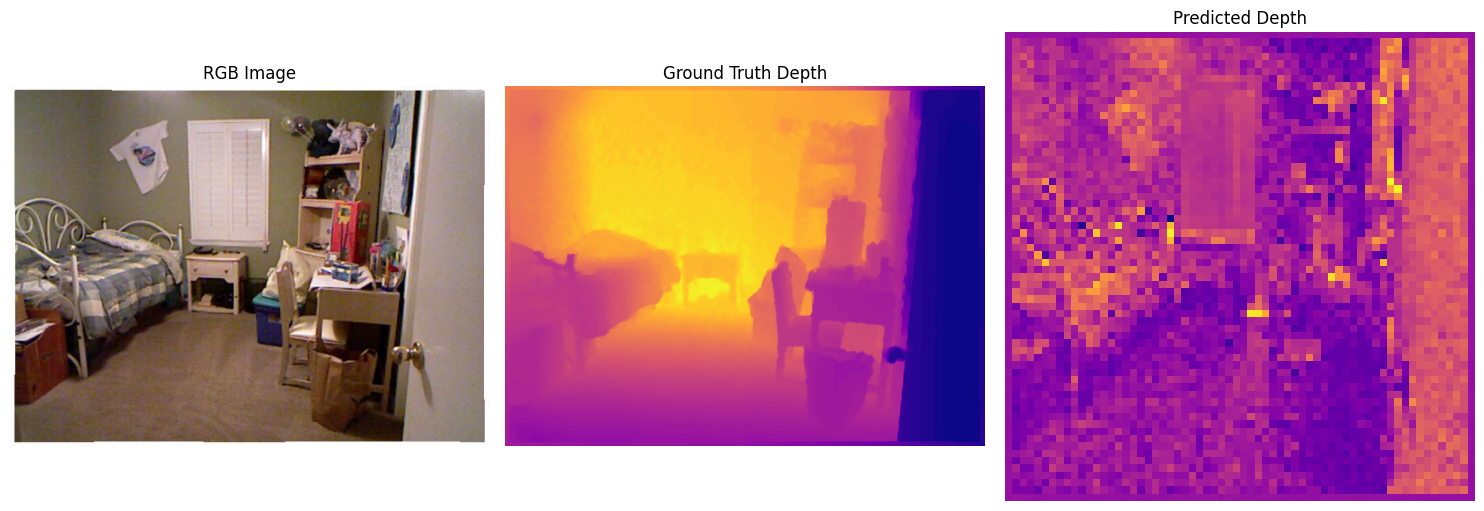

In [21]:
def visualize_full_depth(image_path, ground_truth_path, predicted_depth_map):
    """Visualize RGB image, ground truth depth map, and predicted depth map."""
    # Load RGB image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load ground truth depth
    ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("RGB Image")
    axes[0].axis("off")
    axes[1].imshow(ground_truth, cmap="plasma")
    axes[1].set_title("Ground Truth Depth")
    axes[1].axis("off")
    axes[2].imshow(predicted_depth_map, cmap="plasma")
    axes[2].set_title("Predicted Depth")
    axes[2].axis("off")
    plt.tight_layout()
    plt.show()

# Example call for visualization using XGBoost
sample_idx = 0 # Choose a sample index
rgb_image_path = train_df.iloc[sample_idx, 0]
ground_truth_path = train_df.iloc[sample_idx, 1]

# Predict depth map for visualization (XGBoost)
image_features = extract_pixel_features(rgb_image_path)
predicted_depth_xgb = booster.inplace_predict(scaler.transform(image_features))
predicted_depth_map_xgb = predicted_depth_xgb.reshape(64, 64)

print("Visualizing XGBoost prediction...")
visualize_full_depth(rgb_image_path, ground_truth_path, predicted_depth_map_xgb)

# Predict depth map for visualization (SVM)
predicted_depth_svr = svr.predict(scaler.transform(image_features))
predicted_depth_map_svr = predicted_depth_svr.reshape(64, 64)

print("Visualizing SVM prediction...")
visualize_full_depth(rgb_image_path, ground_truth_path, predicted_depth_map_svr)